In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno  as msno
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score, mean_absolute_error

In [2]:
macapa = pd.read_csv('../data/macapa.txt')

In [3]:
macapa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8604 entries, 0 to 8603
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   codigo_estacao    8604 non-null   object 
 1   data              8604 non-null   object 
 2   hora              8604 non-null   int64  
 3   temp_inst         8604 non-null   float64
 4   temp_max          8604 non-null   float64
 5   temp_min          8604 non-null   float64
 6   umid_inst         8604 non-null   int64  
 7   umid_max          8604 non-null   int64  
 8   umid_min          8604 non-null   int64  
 9   pto_orvalho_inst  8604 non-null   float64
 10  pto_orvalho_max   8604 non-null   float64
 11  pto_orvalho_min   8604 non-null   float64
 12  pressao           8604 non-null   float64
 13  pressao_max       8604 non-null   float64
 14  pressao_min       8604 non-null   float64
 15  vento_vel         7726 non-null   float64
 16  vento_direcao     7731 non-null   float64


# Tratando dados Faltantes

In [4]:
macapa = macapa.drop(columns = ['vento_rajada'])

In [5]:
# tabela percentual de dados faltantes
def tabela_faltantes():
    features_numericas = ["hora","temp_inst", "temp_max", "temp_min", "umid_inst","umid_max","umid_min",
                          "pto_orvalho_inst", "pto_orvalho_max", "pto_orvalho_min","pressao","pressao_max",
                          "pressao_min","vento_vel", "vento_direcao","radiacao","precipitacao"]

    df = macapa[features_numericas]


    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)


    missing_data = pd.concat([total, percent], axis=1,join='outer', keys=['Dados Ausentes', '% Percentual'])
    missing_data.index.name =' Variaveis numericas'
    return missing_data

In [6]:
tabela_faltantes()

,Dados Ausentes,% Percentual
Variaveis numericas,,
vento_vel,878,0.102046
vento_direcao,873,0.101464
precipitacao,2,0.000232
umid_min,0,0.000000
temp_inst,0,0.000000
temp_max,0,0.000000
temp_min,0,0.000000
umid_inst,0,0.000000
umid_max,0,0.000000


In [7]:
# preenchendo os valores ausentes pela media da coluna do mesmo
mean_Vvel = macapa.vento_vel.mean()
macapa['vento_vel'] = macapa['vento_vel'].fillna(mean_Vvel)

mean_vdir = macapa.vento_direcao.mean()
macapa['vento_direcao'] = macapa['vento_direcao'].fillna(mean_vdir)

In [10]:
#//// - > 742 é um problema, vamos converter para NaN e depois tratar esses dados ausentes
macapa['precipitacao'].value_counts()

0.0     6949
0.2      242
0.4      107
0.8       66
0.6       62
        ... 
12.8       1
7.4        1
15.0       1
17.0       1
32.2       1
Name: precipitacao, Length: 82, dtype: int64

In [12]:
# Assim, você já converte os valores existentes para número e os '/' para NaN. 
# Depois se quiser um número no lugar do NaN, pode usar a função fillna() 

macapa['precipitacao'] = pd.to_numeric(macapa['precipitacao'], errors='coerce')

In [13]:
macapa['precipitacao'].value_counts() # resolvido

0.0     6949
0.2      242
0.4      107
0.8       66
0.6       62
        ... 
12.8       1
7.4        1
15.0       1
17.0       1
32.2       1
Name: precipitacao, Length: 82, dtype: int64

In [14]:
tabela_faltantes() # vamos verificar os dados ausentes novamente

,Dados Ausentes,% Percentual
Variaveis numericas,,
precipitacao,744,0.086471
pto_orvalho_inst,0,0.000000
temp_inst,0,0.000000
temp_max,0,0.000000
temp_min,0,0.000000
umid_inst,0,0.000000
umid_max,0,0.000000
umid_min,0,0.000000
pto_orvalho_max,0,0.000000


In [15]:
mean_chuva = macapa['precipitacao'].mean()
macapa['precipitacao'] = macapa['precipitacao'].fillna(mean_chuva)

- Matriz de nulidade

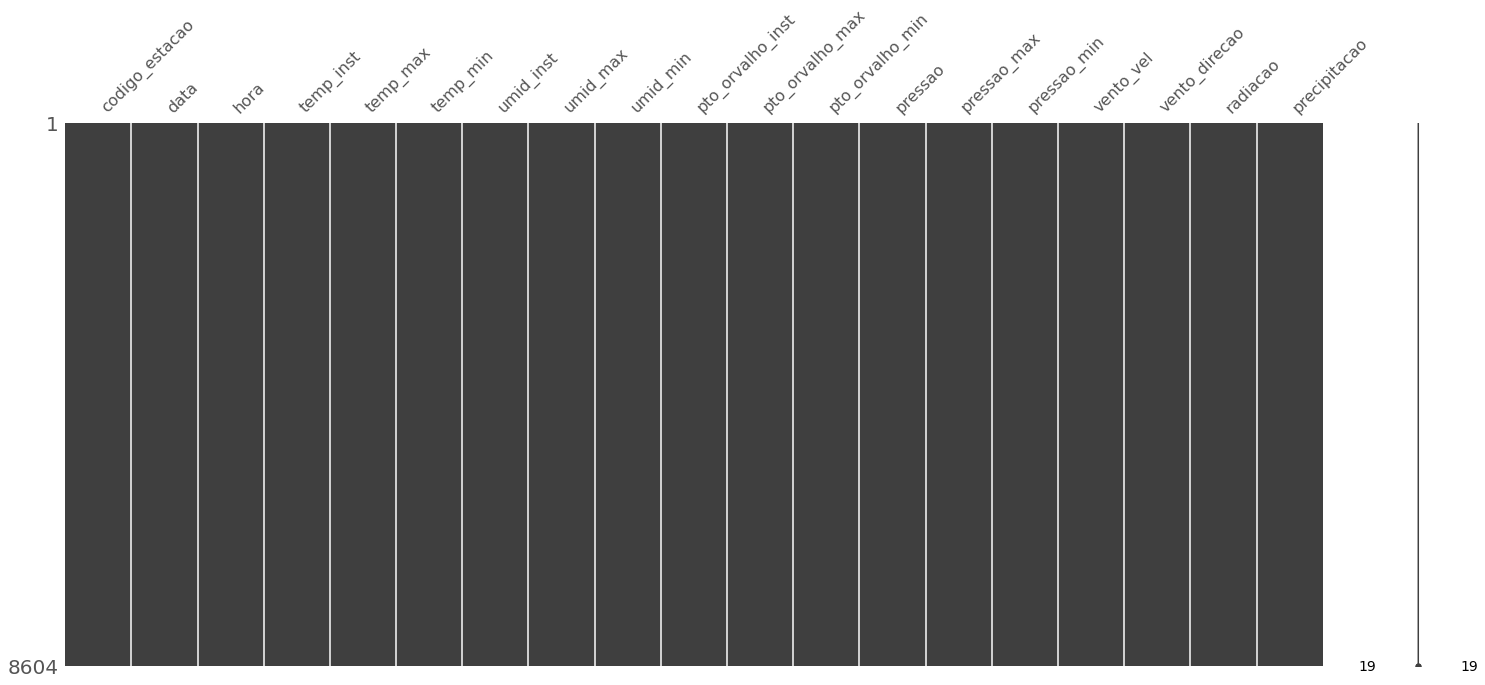

In [16]:
msno.matrix(macapa) # com a matriz de nulidade vemos que os dados estao prontos para o processamento e modelagem

## Seleção de Features 

- Selecionando o nosso X e Y  

In [17]:
macapa.columns

Index(['codigo_estacao', 'data', 'hora', 'temp_inst', 'temp_max', 'temp_min',
       'umid_inst', 'umid_max', 'umid_min', 'pto_orvalho_inst',
       'pto_orvalho_max', 'pto_orvalho_min', 'pressao', 'pressao_max',
       'pressao_min', 'vento_vel', 'vento_direcao', 'radiacao',
       'precipitacao'],
      dtype='object')

In [19]:
y = macapa['precipitacao'] # precipitacao (volume de chuva)
X = macapa.drop(['precipitacao','codigo_estacao','data'], axis=1) # removendo chuva e algumas features 

- Separando em Treino e Teste

In [20]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=0)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape 

((6022, 16), (2582, 16), (6022,), (2582,))

# Modelagem 

In [38]:
k_vs_score = []
for k in range(2, Xtrain.shape[1], 2):
#     selector_model = Lasso(alpha=1, normalize=True)
#     selector_model = LinearRegression(normalize=True)
#     selector_model = Ridge(alpha=0.1, normalize=True)
    selector_model = RandomForestRegressor(random_state=1, n_jobs=-1)
    selector = SelectFromModel(selector_model, max_features=k, threshold=-np.inf)

    selector.fit(Xtrain, ytrain)
    
    Xtrain2 = selector.transform(Xtrain)
    Xtest2 = selector.transform(Xtest)

    print(Xtrain.shape, Xtrain2.shape)
    
#     mdl = RandomForestRegressor(n_estimators=1000, random_state=0, n_jobs=-1)
    mdl = XGBRegressor(objective="reg:squarederror", seed=0)
    mdl.fit(Xtrain2, ytrain)
    prev_chuva = mdl.predict(Xtest2)

    score = mean_absolute_error(ytest, prev_chuva)
    print("k = {} - MAE = {}".format(k, score))
    
    k_vs_score.append(score)

(6022, 16) (6022, 2)
k = 2 - MAE = 0.5057651954444838
(6022, 16) (6022, 4)
k = 4 - MAE = 0.44381408680475737
(6022, 16) (6022, 6)
k = 6 - MAE = 0.3801442234893788
(6022, 16) (6022, 8)
k = 8 - MAE = 0.36390053832595687
(6022, 16) (6022, 10)
k = 10 - MAE = 0.35736432067817697
(6022, 16) (6022, 12)
k = 12 - MAE = 0.37102901932554533
(6022, 16) (6022, 14)
k = 14 - MAE = 0.3621428852406571


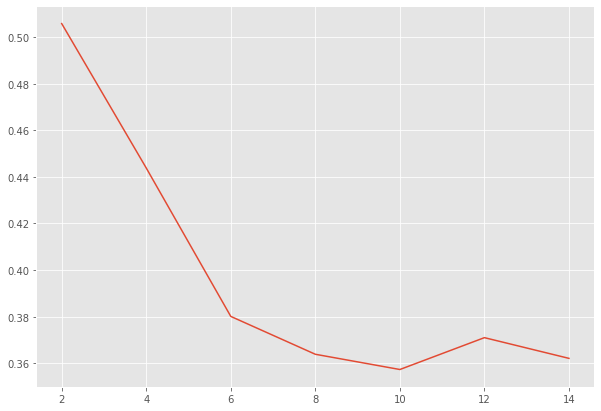

In [39]:
pd.Series(k_vs_score,index=range(2,X.shape[1],2)).plot(figsize=(10,7))

### Quais as features que o modelo selecionou?

- Todas as Features antes do loop

In [24]:
print(f'Total de features: {X.shape[1]}\n{X.columns}')

Total de features: 16
Index(['hora', 'temp_inst', 'temp_max', 'temp_min', 'umid_inst', 'umid_max',
       'umid_min', 'pto_orvalho_inst', 'pto_orvalho_max', 'pto_orvalho_min',
       'pressao', 'pressao_max', 'pressao_min', 'vento_vel', 'vento_direcao',
       'radiacao'],
      dtype='object')


- Depois do loop

In [26]:
mask = selector.get_support()
print(f'Total de Feature {len(Xtrain.columns[mask])}\n{Xtrain.columns[mask]}')

Total de Feature 14
Index(['hora', 'temp_inst', 'temp_max', 'temp_min', 'umid_inst', 'umid_max',
       'umid_min', 'pto_orvalho_inst', 'pto_orvalho_max', 'pto_orvalho_min',
       'pressao', 'pressao_max', 'pressao_min', 'vento_vel'],
      dtype='object')


### Conclusão:
- As feature que saiu foi Radiação e as anteriores que foram dropadas antes de treinar o modelo: data, hora, codigo_estacão

## Avaliando o desempenho do modelo

In [40]:
print(f'𝑅² - Coeficiente de determinação: {r2_score(ytest, prev_chuva).round(8)}') # 𝑅² quanto mais proximo de 1 melhor
print(f'MSE - Erro médio quadrático: {mean_squared_error(ytest, prev_chuva).round(8)}')# Mean Squared Error - mais proximo de 0 melhor
print(f'MAE - Mediana de erros de predição: {median_absolute_error(ytest, prev_chuva).round(8)}') # Median Absolute Error - menor melhor

𝑅² - Coeficiente de determinação: 0.46173574
MSE - Erro médio quadrático: 2.35758686
MAE - Mediana de erros de predição: 0.07040638


## Salvando as Previsões

In [28]:
resultado = pd.Series(prev_chuva)
resultado.to_csv('../output/prev_chuva_macapa.csv',index = False)